In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')  # 设置背景
%matplotlib inline

In [2]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

C:\python\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape,test.shape

((1460, 81), (1459, 80))

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 可视化数据中的特征

In [32]:
# 找到数字特征
numeric_dtypes = ['int16','int32','int64','float16','float32','float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     

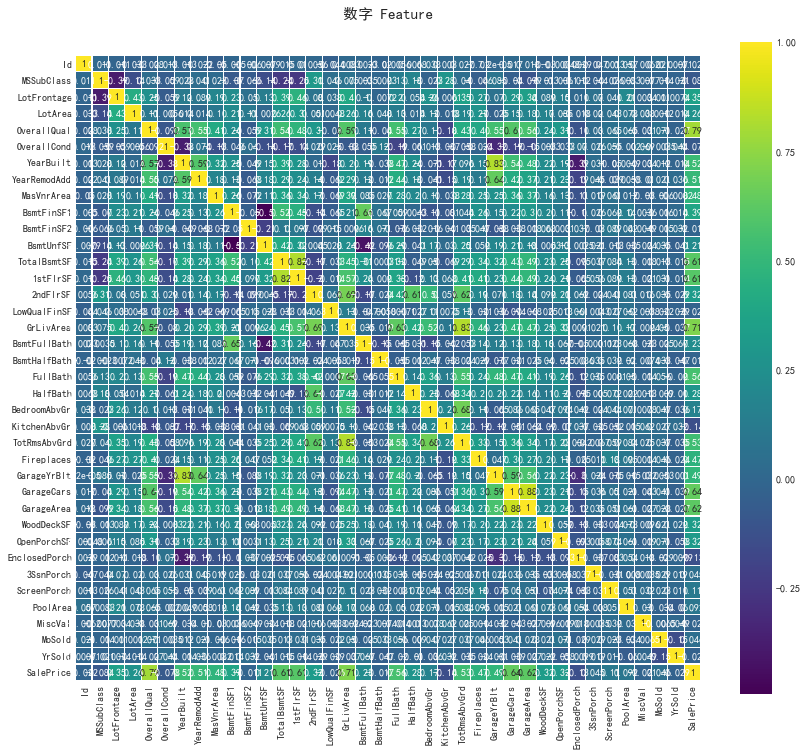

In [28]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(14,12))
colormap = plt.cm.viridis
plt.title('数字 Feature',y = 1.05,size = 15)
# corr()求相关系数
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'],axis = 1,inplace = True)
test.drop(['Id'],axis = 1,inplace = True)
train.shape,test.shape

((1460, 80), (1459, 79))

## 特征工程

C:\python\anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


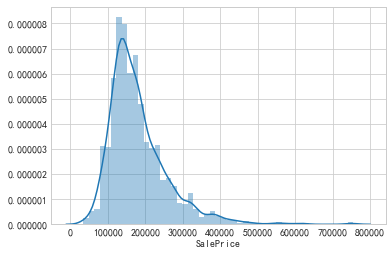

In [31]:
sns.distplot(train['SalePrice'])

In [41]:
train.corr().columns[train.corr().loc['SalePrice']>0.5]

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')

In [92]:
# 找出和SalePrices相关性最高的四个特征
list(train.corr().columns[list(np.argsort(train.corr().loc['SalePrice']))[32:]])

['GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'SalePrice']

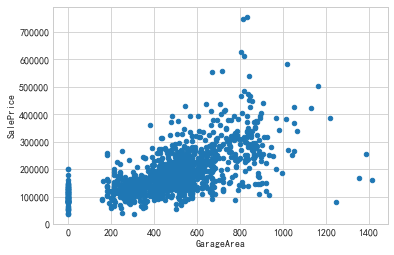

In [93]:
# 使用DataFrame绘制散点图
data = pd.concat([train['SalePrice'],train['GarageArea']],axis = 1)
data.plot.scatter(x = 'GarageArea',y = 'SalePrice')

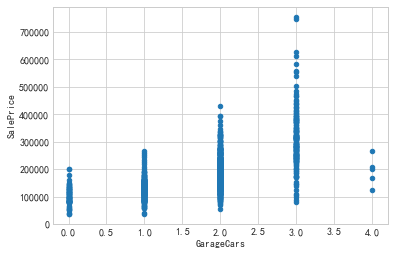

In [94]:
data = pd.concat([train['SalePrice'],train['GarageCars']],axis = 1)
data.plot.scatter(x = 'GarageCars',y = 'SalePrice')

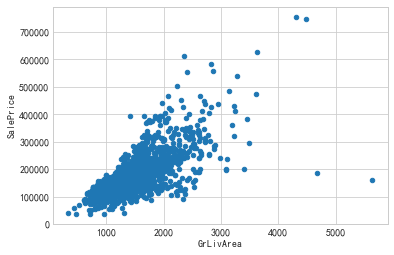

In [95]:
data = pd.concat([train['SalePrice'],train['GrLivArea']],axis = 1)
data.plot.scatter(x = 'GrLivArea',y = 'SalePrice')

In [65]:
train.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

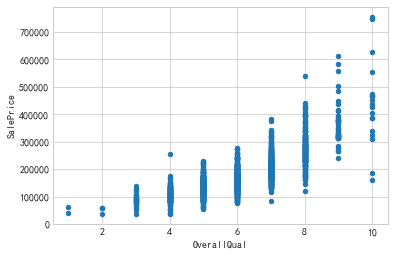

In [98]:
data = pd.concat([train['SalePrice'],train['OverallQual']],axis = 1)
data.plot.scatter(x = 'OverallQual',y = 'SalePrice')

In [100]:
# 去除噪声
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
# 重置索引
train.reset_index(drop=True, inplace=True)

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 80 columns):
MSSubClass       1457 non-null int64
MSZoning         1457 non-null object
LotFrontage      1199 non-null float64
LotArea          1457 non-null int64
Street           1457 non-null object
Alley            91 non-null object
LotShape         1457 non-null object
LandContour      1457 non-null object
Utilities        1457 non-null object
LotConfig        1457 non-null object
LandSlope        1457 non-null object
Neighborhood     1457 non-null object
Condition1       1457 non-null object
Condition2       1457 non-null object
BldgType         1457 non-null object
HouseStyle       1457 non-null object
OverallQual      1457 non-null int64
OverallCond      1457 non-null int64
YearBuilt        1457 non-null int64
YearRemodAdd     1457 non-null int64
RoofStyle        1457 non-null object
RoofMatl         1457 non-null object
Exterior1st      1457 non-null object
Exterior2nd      1457 non-

In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

In [111]:
# 分裂特征
train_labels = train['SalePrice']
train_features = train.drop(['SalePrice'],axis = 1)
test_features = test
# 合并训练集和测试集的特征
all_features = pd.concat([train_features,test_features])
all_features.shape

(2916, 79)

In [113]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2916 non-null int64
MSZoning         2912 non-null object
LotFrontage      2431 non-null float64
LotArea          2916 non-null int64
Street           2916 non-null object
Alley            198 non-null object
LotShape         2916 non-null object
LandContour      2916 non-null object
Utilities        2914 non-null object
LotConfig        2916 non-null object
LandSlope        2916 non-null object
Neighborhood     2916 non-null object
Condition1       2916 non-null object
Condition2       2916 non-null object
BldgType         2916 non-null object
HouseStyle       2916 non-null object
OverallQual      2916 non-null int64
OverallCond      2916 non-null int64
YearBuilt        2916 non-null int64
YearRemodAdd     2916 non-null int64
RoofStyle        2916 non-null object
RoofMatl         2916 non-null object
Exterior1st      2915 non-null object
Exterior2nd      2915 non

## 填充缺失值

In [172]:
# 计算缺失值所占比例
def cal_percent(all_features):
    count=all_features.isnull().sum().sort_values()[all_features.isnull().sum().sort_values()>0]
    ratio=count/len(all_features)
    nulldata=pd.DataFrame({'count':count,'ratio':ratio})
    return nulldata

In [167]:
# 填充缺失值
def fill_missing(features):
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # 将缺失值替换为0，因为有的没有车库
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')    
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
    # 填充中位数
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # 其他特征填充none
    Objects = []
    for i in features.columns:
        if features[i].dtype == object:
            Objects.append(i)
    features.update(features[Objects].fillna('None'))
    # 其他数字特征填充0
    numeric_dtypes = ['int16','int32','int64','float16','float32','float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features

In [157]:
all_features[['MSSubClass','MSZoning']].head()

,MSSubClass,MSZoning
0,60,RL
1,20,RL
2,60,RL
3,70,RL
4,60,RL


In [173]:
# 填充缺失值后
all_features = fill_missing(all_features)
nulldata = cal_percent(all_features)
nulldata

,count,ratio


In [174]:
# corr()只能求数字的相关系数
ttt = pd.DataFrame({'a':['a','b','c'],'b':['b','c','d']})
ttt.corr()

""


## 特征工程

In [175]:
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)
all_features['OverallCond'] = all_features['OverallCond'].astype(str)

In [178]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal


In [179]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2916 non-null object
MSZoning         2916 non-null object
LotFrontage      2916 non-null float64
LotArea          2916 non-null int64
Street           2916 non-null object
Alley            2916 non-null object
LotShape         2916 non-null object
LandContour      2916 non-null object
Utilities        2916 non-null object
LotConfig        2916 non-null object
LandSlope        2916 non-null object
Neighborhood     2916 non-null object
Condition1       2916 non-null object
Condition2       2916 non-null object
BldgType         2916 non-null object
HouseStyle       2916 non-null object
OverallQual      2916 non-null int64
OverallCond      2916 non-null object
YearBuilt        2916 non-null int64
YearRemodAdd     2916 non-null int64
RoofStyle        2916 non-null object
RoofMatl         2916 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 

In [180]:
# 增添特征
# 增加每个房屋地下室，一楼和二楼的总面积
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']

In [186]:
# 房屋内某些区域空间的有无会影响房屋的价格
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1

##### 房屋改造时间（YearsSinceRemodel）与房屋出售时间（YrSold）间隔时间的长短通常也会影响房价

In [187]:
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)

#### 房屋的整体质量也是影响房价的重要要因素

In [190]:
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond'].astype(int)

## 数据转换

In [193]:
quantitative = [i for i in all_features.columns if all_features[i].dtypes != 'object']
# 计算偏度
from scipy.stats import norm, skew #for some statistics
skewed_feats = all_features[quantitative].apply(lambda x:skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({'skew':skewed_feats})
skewness

,skew
MiscVal,21.935910
PoolArea,17.685603
LotArea,13.262550
LowQualFinSF,12.082427
3SsnPorch,11.370087
KitchenAbvGr,4.299698
BsmtFinSF2,4.143683
EnclosedPorch,4.001570
ScreenPorch,3.944305
BsmtHalfBath,3.929197


#### 对偏度大于0.15的，进行log操作以提升质量

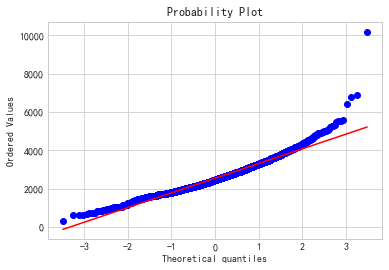

In [207]:
#直观的方式观察偏斜程度.Q-Q图是一个不错的方式
from scipy import stats
res = stats.probplot(all_features['TotalSF'],plot = plt)

C:\python\anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


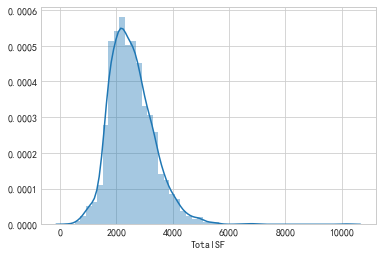

In [208]:
sns.distplot(all_features['TotalSF'])

In [334]:
# 对分布偏度大的数据取对数，修正数据
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        # 添加
        res[l] = pd.Series(np.log(1.01+res[l])).values
    return res
loglist=skewness[abs(skewness)>0.15].index.tolist()
mydata = addlogs(all_features, loglist)
mydata.shape

C:\python\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


(2916, 87)

C:\python\anaconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


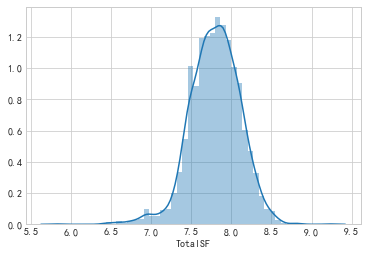

In [291]:
sns.distplot(mydata['TotalSF'])

In [335]:
mydata.shape

(2916, 87)

In [336]:
mydata = pd.get_dummies(mydata)
mydata.shape
mydata.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.648621,2.307776,1.128395,2.153262,2.153262,1.839478,2.024331,0.019754,1.796307,2.049427,...,0,0,0,1,0,0,0,0,1,0
1,1.687245,2.320388,1.084289,2.151686,2.151686,0.019754,2.066425,0.019754,1.896498,2.098172,...,0,0,0,1,0,0,0,0,1,0
2,1.657133,2.335847,1.128395,2.153146,2.153204,1.808913,1.973843,0.019754,1.958032,2.058661,...,0,0,0,1,0,0,0,0,1,0
3,1.633357,2.319875,1.128395,2.148034,2.151332,0.019754,1.854725,0.019754,1.988345,2.033316,...,0,0,0,1,1,0,0,0,0,0
4,1.696124,2.358520,1.165752,2.153088,2.153088,1.927283,2.014393,0.019754,1.974978,2.086174,...,0,0,0,1,0,0,0,0,1,0


In [337]:
mydata['YearsSinceRemodel'] = mydata['YearsSinceRemodel'].fillna(mydata['YearsSinceRemodel'].mean())
mydata['YearsSinceRemodel'].describe()

count    2916.000000
mean        1.193353
std         0.469735
min         0.019754
25%         0.963722
50%         1.330574
75%         1.567452
max         1.633357
Name: YearsSinceRemodel, dtype: float64

### 特征降维

In [321]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
mydata = pd.DataFrame(pca.fit_transform(mydata))

### 分割数据集

In [464]:
X = mydata.iloc[:len(train_labels),:]
X_test = mydata.iloc[len(train_labels):,:]
X.shape,train_labels.shape,X_test.shape

((1457, 348), (1457,), (1459, 348))

In [339]:
mydata.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.648621,2.307776,1.128395,2.153262,2.153262,1.839478,2.024331,0.019754,1.796307,2.049427,...,0,0,0,1,0,0,0,0,1,0
1,1.687245,2.320388,1.084289,2.151686,2.151686,0.019754,2.066425,0.019754,1.896498,2.098172,...,0,0,0,1,0,0,0,0,1,0
2,1.657133,2.335847,1.128395,2.153146,2.153204,1.808913,1.973843,0.019754,1.958032,2.058661,...,0,0,0,1,0,0,0,0,1,0
3,1.633357,2.319875,1.128395,2.148034,2.151332,0.019754,1.854725,0.019754,1.988345,2.033316,...,0,0,0,1,1,0,0,0,0,0
4,1.696124,2.358520,1.165752,2.153088,2.153088,1.927283,2.014393,0.019754,1.974978,2.086174,...,0,0,0,1,0,0,0,0,1,0


### 先试试不同模型的预测效果

In [340]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

In [341]:
X_train = np.array(X)
train_labels = np.array(train_labels)
type(X_train),train_labels

(numpy.ndarray,
 array([208500, 181500, 223500, ..., 266500, 142125, 147500], dtype=int64))

In [343]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)
from sklearn.model_selection import cross_val_score
# k折交叉验证 
scores = np.sqrt(-cross_val_score(svr,X_train, train_labels,scoring="neg_mean_squared_error", cv=kf))
scores.mean()

80668.43341873068

In [347]:
svr.fit(X_train,train_labels)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('svr', SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.008, gamma=0.0003,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [348]:
test_result = svr.predict(X_test)

In [345]:
submission = pd.read_csv('./sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [365]:
test_org = pd.read_csv('./test.csv')
sub=pd.DataFrame()
sub['Id']=test_org['Id']
sub['SalePrice']=test_result

In [366]:
sub

,Id,SalePrice
0,1461,162956.927453
1,1462,163020.026828
2,1463,163070.426656
3,1464,163094.404971
4,1465,163064.110688
5,1466,163069.074203
6,1467,163049.784393
7,1468,163065.841991
8,1469,163067.674746
9,1470,162827.673693


In [367]:
sub.to_csv('./result.csv',index = False)

In [369]:
test_org.shape,sub.shape

((1459, 80), (1459, 2))

In [398]:
# 对分布偏度大的数据取对数，修正数据
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        # 添加
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l+'_log'
        m += 1
    return res
log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']
train_data = addlogs(all_features, log_features)
train_data.shape

(2916, 117)

In [399]:

train_data=pd.get_dummies(train_data)
train_data.shape

(2916, 378)

In [400]:
X = train_data.iloc[:len(train_labels),:]
X_test = train_data.iloc[len(train_labels):,:]
print(X.shape,train_labels.shape,X_test.shape)
kf = KFold(n_splits=12, random_state=42, shuffle=True)
from sklearn.model_selection import cross_val_score
# k折交叉验证 
scores = np.sqrt(-cross_val_score(svr,X, train_labels,scoring="neg_mean_squared_error", cv=kf))
scores.mean()

(1457, 378) (1457,) (1459, 378)


80615.92002453648

In [430]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, Labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [432]:
# 对价格进行对数变换来修复偏斜
Labels = np.log1p(train_labels)

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [445]:
scores = {}
names = {'lightgbm':lightgbm,'xgboost':xgboost,'gbr':gbr,'rf':rf,'svr':svr}
for name,model in names.items():
    score = cv_rmse(model)
    print(name + ": {:.4f} ({:.4f})".format(score.mean(), score.std()))
    scores[model] = (score.mean(), score.std())


lightgbm: 0.1161 (0.0162)
[11:00:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:00:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squa

In [447]:
lightgbm.fit(X,Labels)
result_test = lightgbm.predict(X_test)
result_test

array([11.73979296, 11.98303486, 12.12040232, ..., 11.96702231,
       11.65229396, 12.24739816])

In [448]:
# 将结果转换回来
result_test = np.expm1(result_test)
result_test

array([125465.36130037, 160015.92320539, 183578.35776809, ...,
       157474.04926021, 114953.76232977, 208437.26061861])

## 模型融合

In [449]:
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr,gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [490]:
stack_gen.fit(np.array(X),np.array(Labels))

[17:49:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:51] WARNI

StackingCVRegressor(cv=5,
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.6,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=6000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=42,
       reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.7, verbosity=1),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
          refit=True,
          regressors=(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.6,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=6000,
       n_jobs=1, n...estimators=1200, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_star

In [491]:
stack_result = stack_gen.predict(np.array(X_test))

In [493]:
# 将结果转换回来
stack_result = np.expm1(stack_result)
stack_result

array([124847.66 , 163420.72 , 184445.97 , ..., 166185.27 , 115969.914,
       212037.38 ], dtype=float32)

In [494]:
sub_stack=pd.DataFrame()
sub_stack['Id']=test_org['Id']
sub_stack['SalePrice']=stack_result
sub_stack.to_csv('./submission_stack.csv',index = False)

In [410]:
lightgbm.fit(X,train_labels)
result_test = lightgbm.predict(X_test)

In [415]:
test_org = pd.read_csv('./test.csv')
sub=pd.DataFrame()
sub['Id']=test_org['Id']
sub['SalePrice']=result_test
sub.to_csv('./submission.csv',index = False)